# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf

from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']    
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
classes = pd.read_csv('signnames.csv')
n_classes = classes.shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Check data dimensions

In [4]:
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

Class: 1 Speed limit (30km/h)


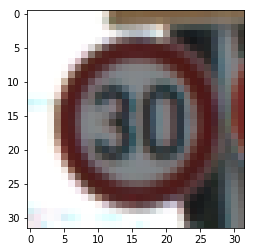

In [16]:
# Show a random image from the training data
n = np.random.randint(n_train)
plt.imshow(X_train[n])
print("Class:", y_train[n], classes['SignName'][y_train[n]])

## Distribution of classes
### Training set

In [6]:
train_classes = np.zeros(n_classes)
y_list = list(y_train)

for c in classes['ClassId']:
    train_classes[c] = y_list.count(c)

Text(0,0.5,'Images')

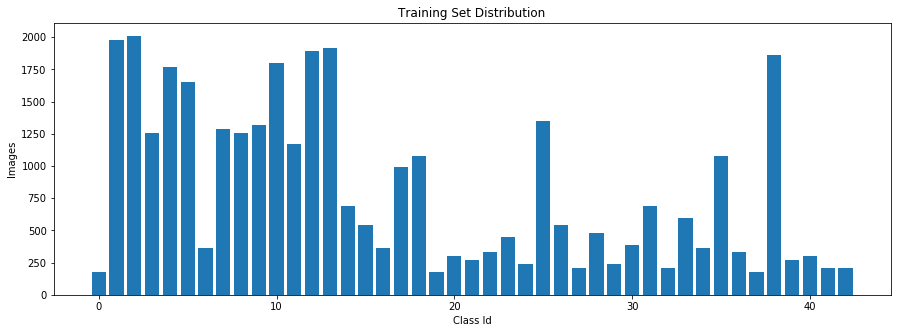

In [7]:
plt.figure(figsize=(15, 5))
plt.bar(classes['ClassId'], train_classes)
plt.title("Training Set Distribution")
plt.xlabel("Class Id")
plt.ylabel("Images")

### Data Augmentation
As we can see in the histogram, we have more images of some classes than others. We should have an equal distribution of examples over all possible classes to be able to predict all of them. I decide to take the classes with less examples and add more data of that class performing data augmentation.

Moreover, if we add more examples to our dataset, this will also help prevent overfitting.

Reference: https://www.geeksforgeeks.org/python-data-augmentation/

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# Initialization of the ImageDataGenerator class.
datagen = ImageDataGenerator( 
        rotation_range = 10, 
        shear_range = 0.2, 
        zoom_range = 0.1)

Using TensorFlow backend.


Concretely, I have taken following images indexes and multiples of how much I have augmented the data:

| Class Id    | 0   | 3  | 6  | 7  | 8  | 9  | 11 | 14 | 15 | 16 | 17 | 18 | 19  | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 30 | 31 | 32 | 33 | 34 | 35 | 36 | 37  | 39 | 40 | 41 | 42 |
|-------------|-----|----|----|----|----|----|----|----|----|----|----|----|-----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|-----|----|----|----|----|
| **Aug. Factor** | x10 | x1 | x5 | x1 | x1 | x1 | x2 | x3 | x2 | x5 | x2 | x2 | x10 | x6 | x7 | x5 | x4 | x6 | x1 | x3 | x7 | x3 | x6 | x3 | x2 | x8 | x3 | x5 | x1 | x5 | x10 | x7 | x6 | x8 | x8 |

In [9]:
# Function for performing data augmentation
def data_aug(idx, aug_factor, data):
    """
    The function takes the class index, the Aug. factor and data type
    and performs data augmentation using parameters defined above.
    
    It saves the data as new jpeg images.
    """
    #Class images
    if data=='train':
        x = X_train[y_train==idx]
        path = '../data/new/'
    elif data=='valid':
        x = X_valid[y_valid==idx]
        path = '../data/new_val/'
        
    # Generating and saving len(x)*aug_factor augmented samples
    for i in range(len(x)):
        #Reshape the image
        img = x[i].reshape((1, 32, 32, 3))
        #Loop for generating new images
        j = 0
        for batch in datagen.flow(x, batch_size = 1, 
                                  save_to_dir =path+str(idx),
                                  save_prefix ='img',
                                  save_format ='jpeg'):
            j += 1
            if j >= aug_factor: 
                break

After generating the data, I add the new images together with the original data in the `../data/new_train.p` pickle file.

In [10]:
new_training_file = "../data/new_train.p"

with open(new_training_file, mode='rb') as f:
    X_train, y_train = pickle.load(f)
    
# New training examples
n_train = X_train.shape[0]

print("Number of new training examples: ", n_train)

Number of new training examples:  92053


### New data distribution
We can now plot the new training data distribution.

In [11]:
train_classes = np.zeros(n_classes)
y_list = list(y_train)

for c in classes['ClassId']:
    train_classes[c] = y_list.count(c)

Text(0,0.5,'Images')

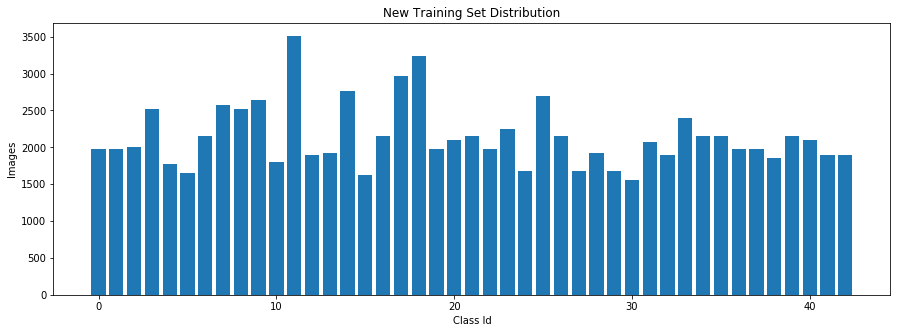

In [12]:
plt.figure(figsize=(15, 5))
plt.bar(classes['ClassId'], train_classes)
plt.title("New Training Set Distribution")
plt.xlabel("Class Id")
plt.ylabel("Images")

As we can see, now the training data is much more uniform over all possible classes.

### Validation set

In [13]:
valid_classes = np.zeros(n_classes)
y_list = list(y_valid)

for c in classes['ClassId']:
    valid_classes[c] = y_list.count(c)

Text(0,0.5,'Images')

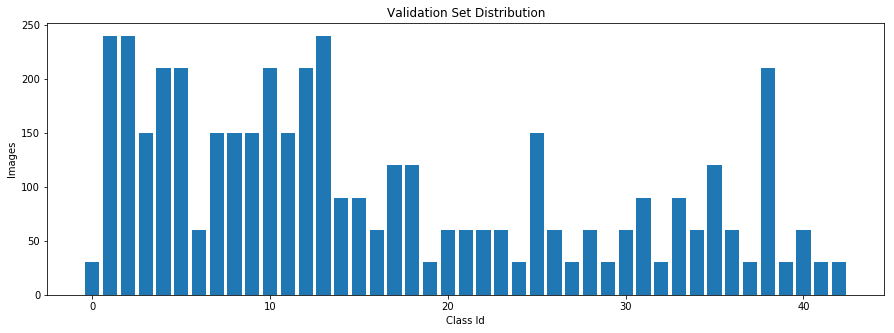

In [14]:
plt.figure(figsize=(15, 5))
plt.bar(classes['ClassId'], valid_classes)
plt.title("Validation Set Distribution")
plt.xlabel("Class Id")
plt.ylabel("Images")

I have also performed data augmentation in the validation set because it has very few examples (4410) compared to the training and test sets. The new data contains around 19000 examples (20% of the new training set) and can be found in `../data/new_valid.p`.

Augmenting the validation set could also prevent overfitting to the validation set. This means, obtaining a high accuracy on the validation set but not so high on the test set.

After using both validation sets for training, I have decided to use the original validation set because it was performing better on the model.

### Test set

In [15]:
test_classes = np.zeros(n_classes)
y_list = list(y_test)

for c in classes['ClassId']:
    test_classes[c] = y_list.count(c)

Text(0,0.5,'Images')

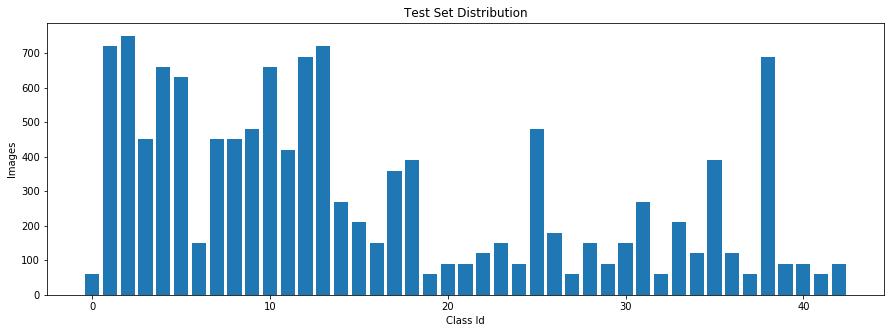

In [16]:
plt.figure(figsize=(15, 5))
plt.bar(classes['ClassId'], test_classes)
plt.title("Test Set Distribution")
plt.xlabel("Class Id")
plt.ylabel("Images")

Here's the test set distribution. I have not touched the test set.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Convert to grayscale & CLAHE

In [17]:
# CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))

def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = clahe.apply(img)
    return img

In [18]:
X_train = np.array(list(map(preprocess, X_train))).reshape(n_train, 32, 32, 1)
X_valid = np.array(list(map(preprocess, X_valid))).reshape(n_validation, 32, 32, 1)
X_test = np.array(list(map(preprocess, X_test))).reshape(n_test, 32, 32, 1)

### Normalization

In [19]:
X_train = (X_train - 128.0)/128.0
X_valid = (X_valid - 128.0)/128.0
X_test = (X_test - 128.0)/128.0

### Model Architecture

In [20]:
def model(x): 
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Weights (for regularization)
    weights = []
    
    #==========  CONV LAYER 1 ==========#
    # Input = 32x32x1. Output = 32x32x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    weights.append(conv1_W)
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    #==========  CONV LAYER 2 ==========#
    # Input = 32x32x16. Output = 32x32x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 16), mean = mu, stddev = sigma))
    weights.append(conv2_W)
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 32x32x16. Output = 16x16x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #==========  CONV LAYER 3 ==========#
    # Input = 16x16x16. Output = 16x16x32.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma))
    weights.append(conv3_W)
    conv3_b = tf.Variable(tf.zeros(32))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    # Activation
    conv3 = tf.nn.relu(conv3)
    
    #==========  CONV LAYER 4 ==========#
    # Input = 16x16x32. Output = 16x16x32.
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma))
    weights.append(conv4_W)
    conv4_b = tf.Variable(tf.zeros(32))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b
    
    #======= Shortcut connection =======#
    # Between conv2 & conv4
    conv2s_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 16, 32), mean = mu, stddev = sigma))
    conv2s_b = tf.Variable(tf.zeros(32))
    conv2 = tf.nn.conv2d(conv2, conv2s_W, strides=[1, 1, 1, 1], padding='VALID') + conv2s_b
    # Addition & Activation.
    conv4 = tf.add(conv2, conv4)
    conv4 = tf.nn.relu(conv4)
    
    # Pooling. Input = 16x16x32. Output = 8x8x32.
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #==========  CONV LAYER 5 ==========#
    # Input = 8x8x32. Output = 8x8x64.
    conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    weights.append(conv5_W)
    conv5_b = tf.Variable(tf.zeros(64))
    conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='SAME') + conv5_b
    # Activation.
    conv5 = tf.nn.relu(conv5)
    
    #==========  CONV LAYER 6 ==========#
    # Input = 8x8x64. Output = 8x8x64.
    conv6_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 64, 64), mean = mu, stddev = sigma))
    weights.append(conv6_W)
    conv6_b = tf.Variable(tf.zeros(64))
    conv6   = tf.nn.conv2d(conv5, conv6_W, strides=[1, 1, 1, 1], padding='VALID') + conv6_b
    
    #======= Shortcut connection =======#
    # Between conv4 & conv6
    conv4s_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 32, 64), mean = mu, stddev = sigma))
    conv4s_b = tf.Variable(tf.zeros(64))
    conv4 = tf.nn.conv2d(conv4, conv4s_W, strides=[1, 1, 1, 1], padding='VALID') + conv4s_b
    # Addition & Activation.
    conv6 = tf.add(conv4, conv6)
    conv6 = tf.nn.relu(conv6)
    
    # Pooling. Input = 8x8x64. Output = 4x4x64.
    conv6 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #========== FLATTEN ==========#    
    fc0 = flatten(conv6) # 1024
    # Dropout
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    #========= FC LAYER 1 ========#
    # Input = 1024. Output = 1024.
    fc1_W  = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean = mu, stddev = sigma))
    fc1_b  = tf.Variable(tf.zeros(1024))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    #========= FC LAYER 2 ========#
    # Input = 1024. Output = 256.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 256), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(256))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation.
    fc2 = tf.nn.relu(fc2)
    #Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    #========= FC LAYER 3 ========#
    # Input = 256. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(256, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    #Dropout
    logits = tf.nn.dropout(logits, keep_prob)
    
    return logits, weights

### Placeholders

In [21]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [22]:
#HYPERMARAMETERS
rate = 0.001
reg_param = 0.0005
EPOCHS = 50
BATCH_SIZE = 512

logits, weights = model(x)

# Cross Entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# Regularization term
regularization = reg_param * sum(list(map(lambda w: tf.nn.l2_loss(w), weights)))

# Total loss
loss_operation = tf.reduce_mean(cross_entropy + regularization)

# Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Evaluation

In [23]:
#Accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Save the model
saver = tf.train.Saver()

#Function for evaluation
def evaluate(X_data, y_data):
    '''
    * It takes x and y data
    * Returns loss and accuracy
    '''
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        #Mini batch
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        #Loss
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        #Accuracy
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        
        #Total
        total_loss += (loss * len(batch_x))
        total_accuracy += (accuracy * len(batch_x))
        
    return total_loss / num_examples, total_accuracy / num_examples

### Training

In [16]:
# List for plotting the results
total_loss = []
total_val_loss = []
total_acc = []
total_val_acc = []

with tf.Session() as sess:
    #Variables initialization
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    #For each epoch
    for i in range(EPOCHS):
        #Shuffle the data
        X_train, y_train = shuffle(X_train, y_train)
        
        #For each mini batch
        for offset in range(0, num_examples, BATCH_SIZE):
            #Mini batch definition
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            #One forward and backward pass
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        #Print evaluation metrics
        print("EPOCH {} ...".format(i+1))
        
        #Training loss & accuracy
        loss, accuracy = evaluate(X_train, y_train)
        print("Loss = {:.3f}".format(loss), 
              "Accuracy = {:.3f}".format(accuracy))
        total_loss.append(loss)
        total_acc.append(accuracy)
        
        #Validation loss & accuracy
        val_loss, val_accuracy = evaluate(X_valid, y_valid)
        print("Val_Loss = {:.3f}".format(val_loss), 
              "Val_Accuracy = {:.3f}".format(val_accuracy))
        total_val_loss.append(val_loss)
        total_val_acc.append(val_accuracy)
        print()
        
    #Save the model
    saver.save(sess, './save_model/model.chkpt')
    print("Model saved")

Training...

EPOCH 1 ...
Loss = 3.491 Accuracy = 0.198
Val_Loss = 3.602 Val_Accuracy = 0.134

EPOCH 2 ...
Loss = 1.504 Accuracy = 0.797
Val_Loss = 1.763 Val_Accuracy = 0.708

EPOCH 3 ...
Loss = 0.672 Accuracy = 0.913
Val_Loss = 0.837 Val_Accuracy = 0.870

EPOCH 4 ...
Loss = 0.369 Accuracy = 0.958
Val_Loss = 0.470 Val_Accuracy = 0.935

EPOCH 5 ...
Loss = 0.272 Accuracy = 0.970
Val_Loss = 0.395 Val_Accuracy = 0.947

EPOCH 6 ...
Loss = 0.182 Accuracy = 0.983
Val_Loss = 0.248 Val_Accuracy = 0.967

EPOCH 7 ...
Loss = 0.138 Accuracy = 0.988
Val_Loss = 0.198 Val_Accuracy = 0.971

EPOCH 8 ...
Loss = 0.127 Accuracy = 0.990
Val_Loss = 0.177 Val_Accuracy = 0.975

EPOCH 9 ...
Loss = 0.111 Accuracy = 0.991
Val_Loss = 0.182 Val_Accuracy = 0.971

EPOCH 10 ...
Loss = 0.102 Accuracy = 0.993
Val_Loss = 0.161 Val_Accuracy = 0.974

EPOCH 11 ...
Loss = 0.091 Accuracy = 0.995
Val_Loss = 0.145 Val_Accuracy = 0.981

EPOCH 12 ...
Loss = 0.091 Accuracy = 0.995
Val_Loss = 0.148 Val_Accuracy = 0.976

EPOCH 13 ...

### Loss history

Text(0.5, 0, 'Epochs')

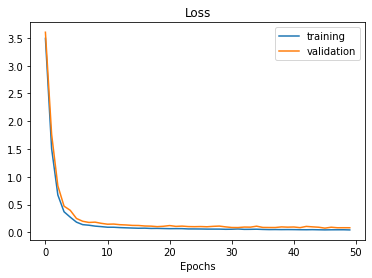

In [17]:
plt.plot(total_loss)
plt.plot(total_val_loss)
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epochs')

### Accuracy history

Text(0.5, 0, 'Epochs')

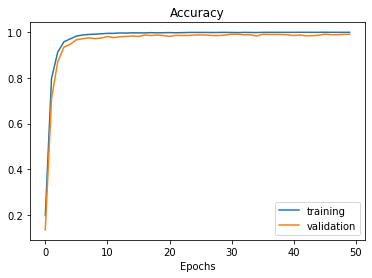

In [18]:
plt.plot(total_acc)
plt.plot(total_val_acc)
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

### Test Accuracy

In [36]:
with tf.Session() as sess:
    saver.restore(sess, './save_model/model.chkpt')

    _, test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./save_model/model.chkpt
Test Accuracy = 0.980


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [24]:
import os
from PIL import Image

# New images path
path = '../data/new_imgs/'

new_imgs = []

for i in range(1,6):
    img = np.array(Image.open(path+'img'+str(i)+'.jpg'))
    img = cv2.resize(img, (32, 32))
    new_imgs.append(img)

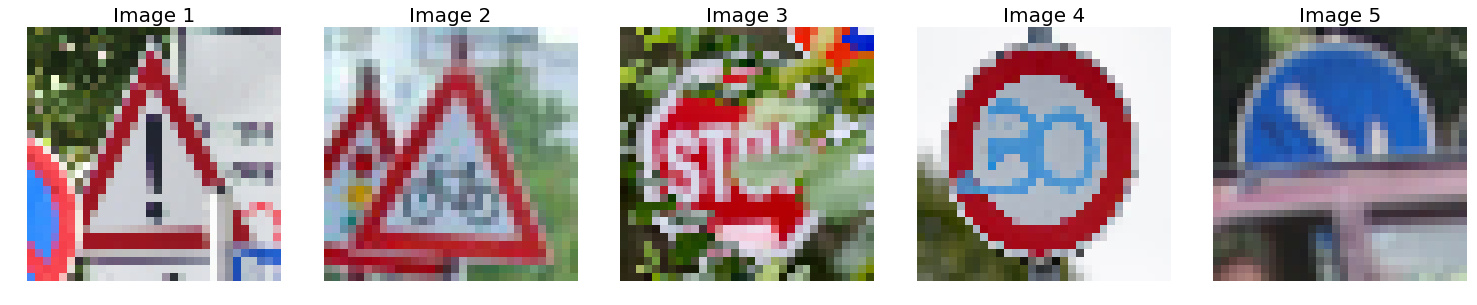

In [25]:
# Images visualization
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,20))
f.tight_layout()
ax1.imshow(new_imgs[0])
ax1.set_title('Image 1', fontsize=20)
ax1.axis("off")
ax2.imshow(new_imgs[1])
ax2.set_title('Image 2', fontsize=20)
ax2.axis("off")
ax3.imshow(new_imgs[2])
ax3.set_title('Image 3', fontsize=20)
ax3.axis("off")
ax4.imshow(new_imgs[3])
ax4.set_title('Image 4', fontsize=20)
ax4.axis("off")
ax5.imshow(new_imgs[4])
ax5.set_title('Image 5', fontsize=20)
ax5.axis("off")
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Preprocess the images

In [26]:
pre_imgs = np.array(list(map(preprocess, new_imgs))).reshape(len(new_imgs), 32, 32, 1)
pre_imgs = (pre_imgs - 128.0)/128.0

### Predict the Sign Type for Each Image

In [27]:
# Output prediction
prediction = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, './save_model/model.chkpt')
    pred_classes = sess.run(prediction, feed_dict={x: pre_imgs, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ./save_model/model.chkpt


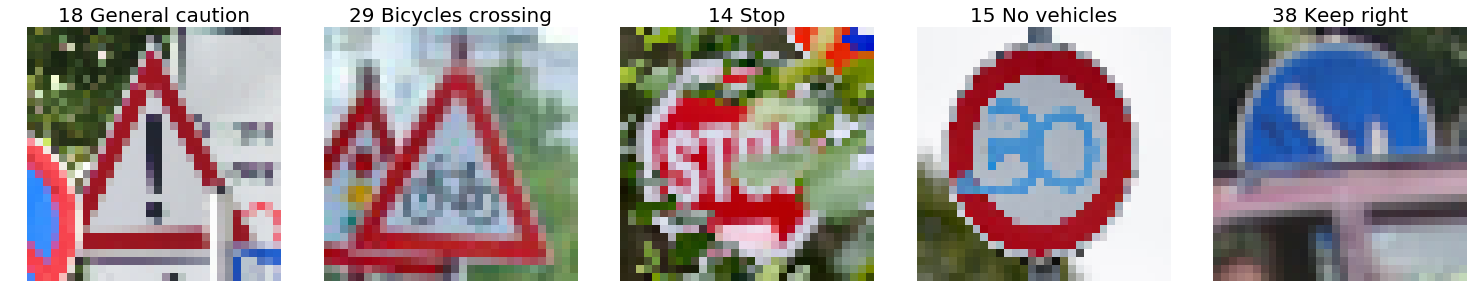

In [28]:
# Show predictions for each image
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,20))
f.tight_layout()
ax1.imshow(new_imgs[0])
ax1.set_title(str(pred_classes[0])+" "+classes['SignName'][pred_classes[0]], fontsize=20)
ax1.axis("off")
ax2.imshow(new_imgs[1])
ax2.set_title(str(pred_classes[1])+" "+classes['SignName'][pred_classes[1]], fontsize=20)
ax2.axis("off")
ax3.imshow(new_imgs[2])
ax3.set_title(str(pred_classes[2])+" "+classes['SignName'][pred_classes[2]], fontsize=20)
ax3.axis("off")
ax4.imshow(new_imgs[3])
ax4.set_title(str(pred_classes[3])+" "+classes['SignName'][pred_classes[3]], fontsize=20)
ax4.axis("off")
ax5.imshow(new_imgs[4])
ax5.set_title(str(pred_classes[4])+" "+classes['SignName'][pred_classes[4]], fontsize=20)
ax5.axis("off")
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Analyze Performance

In [29]:
### Calculate the accuracy for these 5 new images.

# Groundtruth labels
y5 = [18, 29, 14, 15, 38]

with tf.Session() as sess:
    saver.restore(sess, './save_model/model.chkpt')

    _, new5_accuracy = evaluate(pre_imgs, y5)
    print("Accuracy of 5 images = {:.3f}".format(new5_accuracy))

INFO:tensorflow:Restoring parameters from ./save_model/model.chkpt
Accuracy of 5 images = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [30]:
with tf.Session() as sess:
    saver.restore(sess,'./save_model/model.chkpt')
    
    # Softmax output
    softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: pre_imgs, keep_prob: 1.0})
    
    # Top 5 probabilities
    top5 = sess.run(tf.nn.top_k(tf.constant(softmax), k=5))

INFO:tensorflow:Restoring parameters from ./save_model/model.chkpt


In [31]:
# Function for plotting the probabilities
def top5_plotting(n):
    """
    n: image number
    Output: image with bar plotting
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3.5), gridspec_kw={'width_ratios': [1, 3]})
    f.tight_layout()
    ax1.imshow(new_imgs[n])
    ax1.set_title("Image "+str(n+1), fontsize=20)
    ax1.axis("off")
    ax2.bar(range(1,6), top5[0][n], tick_label=classes['SignName'][top5[1][n]])
    ax2.set_title("Top 5 Softmax Probabilities", fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

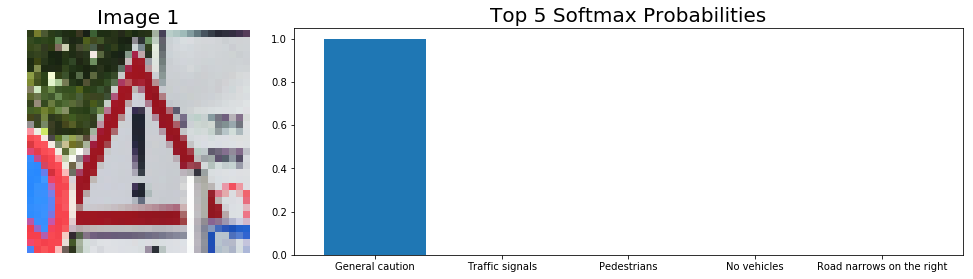

In [32]:
top5_plotting(0)

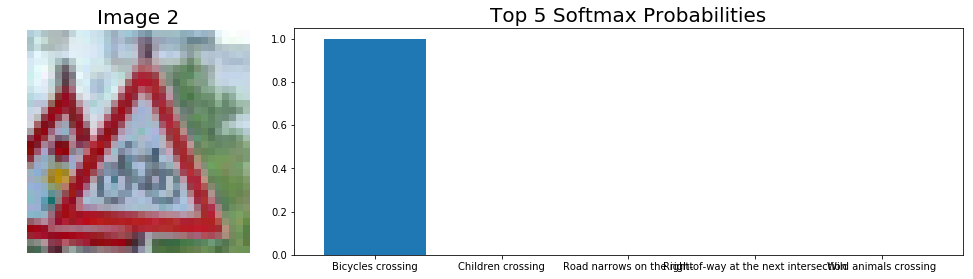

In [33]:
top5_plotting(1)

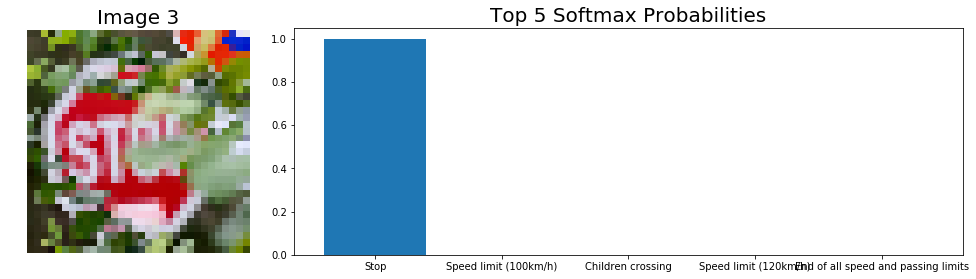

In [34]:
top5_plotting(2)

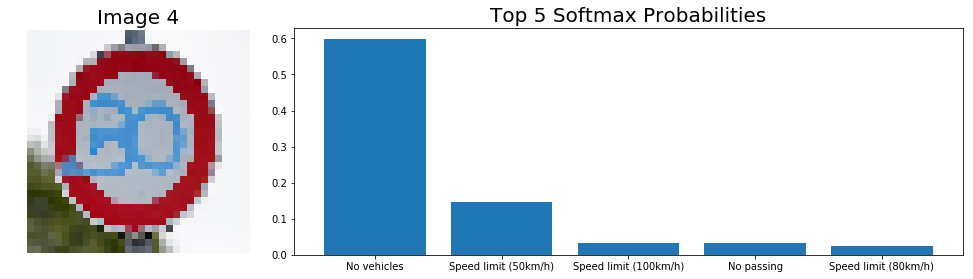

In [35]:
top5_plotting(3)

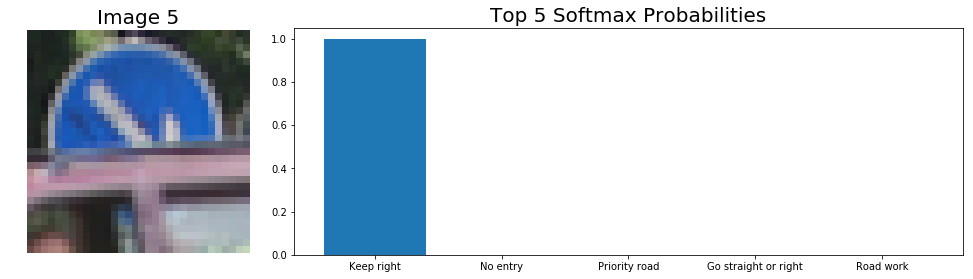

In [36]:
top5_plotting(4)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [33]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")